In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import SmoothL1Loss, Softplus
import os

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
pkg = np.load("phase0_package.npz", allow_pickle=True)
splits = np.load("phase0_splits.npz", allow_pickle=True)

In [5]:
kspace_c = pkg['kspace_c']
sens = pkg['sens']

Gamma_mask = splits["Gamma_mask"]
R_mask = splits["R_mask"]
Theta_masks = np.stack([m.astype(bool) for m in splits["Theta_mask_list"]], axis=0)
Lambda_masks = np.stack([m.astype(bool) for m in splits["Lambda_mask_list"]], axis=0)

Theta1_mask = Theta_masks[0]
Lambda1_mask = Lambda_masks[0]

Omega_mask = np.logical_or(Gamma_mask, R_mask)

In [6]:
def bmask(M: torch.Tensor) -> torch.Tensor:
    # returns shape (1,1,ky,kz) for broadcasting over (C, x, ky, kz)
    return M[None, None, :, :]

In [7]:
ksp = torch.as_tensor(kspace_c, dtype=torch.complex64, device=device)  # (C, col, lin, par)
sens_t = torch.as_tensor(sens, dtype=torch.complex64, device=device)   # same shape

Gamma_mask_t = torch.as_tensor(Gamma_mask.astype(bool), dtype=torch.bool, device=device)  # (lin, par)
R_mask_t = torch.as_tensor(R_mask.astype(bool), dtype=torch.bool, device=device)

Theta1_mask_t = torch.as_tensor(Theta1_mask.astype(bool), dtype=torch.bool, device=device)
Lambda1_mask_t = torch.as_tensor(Lambda1_mask.astype(bool), dtype=torch.bool, device=device)

Omega_mask_t = torch.as_tensor(Omega_mask.astype(bool), dtype=torch.bool, device=device)

In [8]:
b_Omega_mask_t = bmask(Omega_mask_t)
b_Theta1_mask_t = bmask(Theta1_mask_t)
b_Lambda1_mask_t = bmask(Lambda1_mask_t)
b_R_mask_t = bmask(R_mask_t)
b_Gamma_mask_t = bmask(Gamma_mask_t)

In [9]:
def complex_to_chan(x: torch.Tensor) -> torch.Tensor:
    """
    Convert a complex tensor of shape (..., H, W) to real tensor with
    a 2-channel representation for real and imaginary parts:
        output shape (..., 2, H, W)
    """
    if not torch.is_complex(x):
        raise ValueError(f"Expected complex input, got dtype {x.dtype}")
    *prefix, H, W = x.shape
    x_flat = x.reshape(-1, H, W)  # flatten prefix dims
    stacked = torch.stack([x_flat.real, x_flat.imag], dim=1)  # (N, 2, H, W)
    return stacked.reshape(*prefix, 2, H, W)

def chan_to_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Convert a real tensor with real/imag channels (..., 2, H, W) back to complex (..., H, W).
    """
    if x.shape[-3] != 2:
        raise ValueError(f"Expected channel dimension of size 2 at -3, got shape {x.shape}")
    real, imag = x.unbind(dim=-3)
    return torch.complex(real, imag)


def count_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels=64, scale=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=True)
        self.scale = scale

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="linear")
        if self.conv1.bias is not None:
            nn.init.zeros_(self.conv1.bias)
        if self.conv2.bias is not None:
            nn.init.zeros_(self.conv2.bias)

    def _core(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = out * self.scale
        return out

    def forward(self, x):
        out = torch.utils.checkpoint.checkpoint(self._core, x, use_reentrant=False)
        return x + out


class ResNetPrior2D(nn.Module):
    def __init__(
        self,
        num_blocks=15,
        in_channels=2,
        base_channels=64,
        out_channels=2,
        scale=0.1,
        predict_residual: bool = True,  # if True, network predicts correction; else full output
    ):
        super().__init__()
        self.predict_residual = predict_residual
        self.in_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1, bias=True)
        self.blocks = nn.Sequential(*[ResidualBlock(base_channels, scale=scale) for _ in range(num_blocks)])
        self.out_conv = nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1, bias=True)

        # Initialization
        nn.init.kaiming_normal_(self.in_conv.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.out_conv.weight, nonlinearity="linear")
        if self.in_conv.bias is not None:
            nn.init.zeros_(self.in_conv.bias)
        if self.out_conv.bias is not None:
            nn.init.zeros_(self.out_conv.bias)

    def forward(self, x_complex: torch.Tensor) -> torch.Tensor:
        """
        x_complex: complex tensor of shape [B, H, W] or [B, 1, H, W]
        Returns: complex tensor of same spatial shape [B, H, W]; if predict_residual=True,
                 this is the residual correction, otherwise the regularized output.
        """
        x = x_complex
        # unify shape: strip singleton channel if present
        if x.ndim == 4 and x.shape[1] == 1:
            x = x.squeeze(1)  # [B, H, W]
        if x.ndim != 3:
            raise ValueError(f"Expected input of shape [B, H, W] or [B,1,H,W], got {x.shape}")

        # convert to 2-channel real representation
        x_chan = complex_to_chan(x)  # [B, 2, H, W]
        out = self.in_conv(x_chan)
        out = self.blocks(out)
        out = self.out_conv(out)  # [B, 2, H, W]
        out_complex = chan_to_complex(out)  # [B, H, W]

        if self.predict_residual:
            return out_complex  # residual (to be added externally)
        else:
            return x + out_complex  # full output (input + correction)

In [11]:
def A(x: torch.Tensor,
      mask: torch.Tensor,
      sens: torch.Tensor) -> torch.Tensor:
    """
    Forward model: image → undersampled k-space.
    x    : [X, Y, Z] complex64
    mask : [1, 1, Y, Z]
    sens : [C, X, Y, Z]
    returns y : [C, X, Y, Z] complex64
    """
    # coil images: [C, X, Y, Z]
    x_coils = sens * x.unsqueeze(0)
    # full 3D FFT on (X,Y,Z)
    y_full = torch.fft.fftn(x_coils, dim=(1,2,3), norm="ortho")
    # apply sampling mask (broadcasts over coil & X)
    return y_full * mask


def AH(y: torch.Tensor,
       mask: torch.Tensor,
       sens: torch.Tensor) -> torch.Tensor:
    """
    Adjoint model: undersampled k-space → image.
    y    : [C, X, Y, Z] complex64
    mask : [1, 1, Y, Z]
    sens : [C, X, Y, Z]
    returns x : [X, Y, Z] complex64
    """
    # zero out unmeasured lines
    y_masked = y * mask
    # inverse 3D FFT
    x_coils = torch.fft.ifftn(y_masked, dim=(1,2,3), norm="ortho")
    # coil-combine: sum conj(sens) * coil images
    return torch.sum(torch.conj(sens) * x_coils, dim=0)


def normal_op(x: torch.Tensor,
              mask: torch.Tensor,
              sens: torch.Tensor,
              lam: float) -> torch.Tensor:
    """
    (A^H A + λ I) x
    x    : [X, Y, Z] complex64
    mask : [1, 1, Y, Z]
    sens : [C, X, Y, Z]
    lam  : float
    """
    return AH(A(x, mask, sens), mask, sens) + lam * x

In [12]:
def cg_sense(b: torch.Tensor,
             mask: torch.Tensor,
             sens: torch.Tensor,
             lam: float,
             iters: int = 10,
             tol: float = 1e-6,
             x0: torch.Tensor = None) -> torch.Tensor:
    """
    Solve (A^H A + lam I) x = b via conjugate gradients, using your normal_op.
    b    : RHS image, complex [X,Y,Z]
    mask : sampling mask [1,1,Y,Z]
    sens : coil sens [C,X,Y,Z]
    lam  : regularization weight
    iters: max CG iterations
    tol  : relative-residual tolerance
    x0   : optional init guess, same shape as b
    """
    # init
    x = x0.clone() if x0 is not None else torch.zeros_like(b)
    r = b - normal_op(x, mask, sens, lam)
    p = r.clone()
    rsold = torch.sum(torch.conj(r) * r).real

    for i in range(iters):
        Ap = normal_op(p, mask, sens, lam)
        denom = torch.sum(torch.conj(p) * Ap).real
        alpha = rsold / (denom + 1e-20)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = torch.sum(torch.conj(r) * r).real
        if torch.sqrt(rsnew) < tol * torch.sqrt(rsold):
            break
        p = r + (rsnew / (rsold + 1e-20)) * p
        rsold = rsnew

    return x

In [13]:
def apply_prior_3d(prior_net, x3d):
    """
    x3d: complex tensor of shape (X,Y,Z)
    prior_net: expects input of shape [B, H, W] complex, treating B as batch of slices
    Returns residual r of same shape (X,Y,Z)
    """
    # Permute to (Z, X, Y) so each z-slice is a batch element
    x_slices = x3d.permute(2, 0, 1)  # (Z, X, Y)
    # Pass through prior: output shape (Z, X, Y)
    r_slices = prior_net(x_slices)  # complex
    # Permute back to (X, Y, Z)
    r = r_slices.permute(1, 2, 0)
    return r

In [14]:
train_masks = []
for i in range(10):
    t = Theta_masks[i]
    l = Lambda_masks[i]
    t = torch.as_tensor(t.astype(bool), dtype=torch.bool, device=device)
    l = torch.as_tensor(l.astype(bool), dtype=torch.bool, device=device)
    train_masks.append((bmask(t), bmask(l)))

In [15]:
def kspace_l1_l2_loss(y_pred, y_true, alpha=0.5, eps=1e-6):
    diff = y_pred - y_true
    mag  = torch.abs(diff)
    l1   = mag.mean()
    l2   = (mag**2).mean()
    return alpha*l1 + (1-alpha)*l2

In [16]:
def train_one_epoch(
    prior, opt,
    ksp, sens,
    train_masks,
    A, AH, cg_sense,
    lam=1e-1, unroll_iters=10,
    cg_iters=25, cg_tol=1e-6,
    gamma=0.1, alpha=0.5,
    device=device
):
    prior.train()
    running = {"true": 0.0, "surr": 0.0, "grad": 0.0}

    idx = torch.randperm(len(train_masks))
    masks = []
    for i in idx:
        masks.append(train_masks[i])

    for mask_t, mask_l in masks:
        opt.zero_grad()

        # 1) Theta-anchor
        y_t      = ksp * mask_t
        Ah_y     = AH(y_t, mask_t, sens)
        x_theta  = cg_sense(Ah_y, mask_t, sens, lam, cg_iters, cg_tol)

        # 2) unroll with DC under no_grad
        x_dc, x_tilde = x_theta.clone(), None
        for _ in range(unroll_iters):
            r       = apply_prior_3d(prior, x_dc)
            x_tilde = x_theta + gamma * r
            # with torch.no_grad(): -> commeneted out after increasing vram to 48gb
            rhs  = Ah_y + lam * x_tilde
            x_dc = cg_sense(rhs, mask_t, sens, lam, cg_iters, cg_tol)
                
        # 3) compute train losses
        y_l       = ksp * mask_l
        y_pred    = A(x_dc, mask_l, sens)
        true_loss = kspace_l1_l2_loss(y_pred, y_l, alpha)

        y_tilde_p   = A(x_tilde, mask_l, sens)
        surr_loss   = kspace_l1_l2_loss(y_tilde_p, y_l, alpha)

        # 4) backward surrogate + step
        # surr_loss.backward()
        true_loss.backward()
        torch.nn.utils.clip_grad_norm_(prior.parameters(), 1e-4)
        grad_norm = torch.sqrt(sum(p.grad.norm()**2 for p in prior.parameters()))
        opt.step()

        # 5) accumulate for logging
        running["true"] += true_loss.item()
        running["surr"] += surr_loss.item()
        running["grad"] += grad_norm.item()

    # average over the 10 steps
    for k in running:
        running[k] /= len(train_masks)
    return running

In [17]:
@torch.no_grad()
def validate(
    prior,
    ksp, sens,
    mask_t, mask_l,
    A, AH, cg_sense,
    lam=1e-1, unroll_iters=10,
    cg_iters=25, cg_tol=1e-6,
    gamma=0.1, alpha=0.5,
    device=device
):
    prior.eval()
    # same pipeline but only true loss on final DC output
    y_t      = ksp * mask_t
    Ah_y     = AH(y_t, mask_t, sens)
    x_theta  = cg_sense(Ah_y, mask_t, sens, lam, cg_iters, cg_tol)
    x_dc     = x_theta.clone()

    for _ in range(unroll_iters):
        r    = apply_prior_3d(prior, x_dc)
        x_dc = cg_sense(
            Ah_y + lam*(x_theta + gamma*r),
            mask_t, sens, lam, cg_iters, cg_tol
        )

    y_pred   = A(x_dc, mask_l, sens)
    return kspace_l1_l2_loss(y_pred, y_t, alpha).item()

In [18]:
prior = ResNetPrior2D().to(device)
opt   = torch.optim.Adam(prior.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-3,
)

history = []
best_val = float("inf")
no_improve_count = 0
no_improve_patience = 3


for epoch in range(1, 51):
    stats = train_one_epoch(
        prior, opt,
        ksp, sens_t,
        train_masks,
        A, AH, cg_sense,
        lam=2e-2, unroll_iters=5,
        cg_iters=10, cg_tol=1e-6,
        gamma=5e-2, alpha=0.5,
        device=device
    )
    val_loss = validate(
        prior,
        ksp, sens_t,
        b_Gamma_mask_t, b_Gamma_mask_t,
        A, AH, cg_sense,
        lam=2e-2, unroll_iters=10,
        cg_iters=10, cg_tol=1e-6,
        gamma=5e-2, alpha=0.5,
        device=device
    )

    scheduler.step(val_loss)

    checkpoint = {
        "epoch": epoch,
        "valid_loss_min":val_loss,
        "model_state": prior.state_dict(),
        "optim_state": opt.state_dict()
    }

    if val_loss < best_val - 1e-9:      # tiny epsilon for numeric stability
        best_val = val_loss
        torch.save(checkpoint, os.path.join("best_prior.pth")) 
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    print(f"[Epoch {epoch:2d}] "
          f"train_true={stats['true']:.3e}, "
          f"train_surr={stats['surr']:.3e}, "
          f"‖∇prior‖={stats['grad']:.3e}, "
          f"val_true={val_loss:.3e} "
          f"LR={opt.param_groups[0]['lr']:.1e}")
    history.append({**stats})

    if no_improve_count >= no_improve_patience:
        print(f"Stopping early at epoch {epoch}, best_val={best_val:.3e}")
        break

[Epoch  1] train_true=1.630e-06, train_surr=1.642e-06, ‖∇prior‖=2.113e-06, val_true=3.191e-07 LR=5.0e-04
[Epoch  2] train_true=1.619e-06, train_surr=1.629e-06, ‖∇prior‖=1.509e-06, val_true=3.181e-07 LR=5.0e-04
[Epoch  3] train_true=1.613e-06, train_surr=1.621e-06, ‖∇prior‖=1.449e-06, val_true=3.166e-07 LR=5.0e-04
[Epoch  4] train_true=1.607e-06, train_surr=1.615e-06, ‖∇prior‖=1.746e-06, val_true=3.154e-07 LR=5.0e-04
[Epoch  5] train_true=1.602e-06, train_surr=1.611e-06, ‖∇prior‖=1.975e-06, val_true=3.149e-07 LR=5.0e-04
[Epoch  6] train_true=1.597e-06, train_surr=1.608e-06, ‖∇prior‖=2.915e-06, val_true=3.136e-07 LR=5.0e-04
[Epoch  7] train_true=1.590e-06, train_surr=1.603e-06, ‖∇prior‖=2.602e-06, val_true=3.116e-07 LR=5.0e-04
[Epoch  8] train_true=1.581e-06, train_surr=1.598e-06, ‖∇prior‖=2.705e-06, val_true=3.105e-07 LR=5.0e-04
[Epoch  9] train_true=1.571e-06, train_surr=1.595e-06, ‖∇prior‖=3.471e-06, val_true=3.123e-07 LR=5.0e-04
[Epoch 10] train_true=1.559e-06, train_surr=1.595e-06, 

‖r_last‖ = 8.908e+00


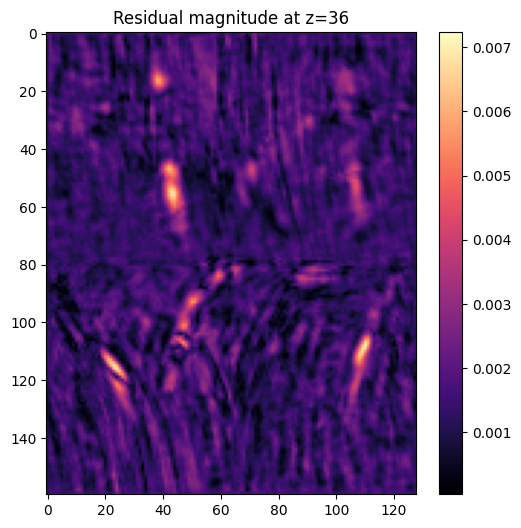

In [60]:
# 1) Load checkpoint
prior_2 = ResNetPrior2D().to(device)
ckpt = torch.load("best_prior.pth", map_location=device)
prior_2.load_state_dict(ckpt["model_state"])

# 2) Switch to eval mode
prior_2.eval()

# 3) Inference function
@torch.no_grad()
def infer(prior, ksp_full, sens, mask_full, A, AH, cg_sense,
          lam=1e-2, unroll_iters=10, cg_iters=25, cg_tol=1e-6, gamma=0.1):
    # anchor
    y = ksp_full * mask_full
    Ah_y = AH(y, mask_full, sens)
    x = cg_sense(Ah_y, mask_full, sens, lam, cg_iters, cg_tol)

    # unroll DC+prior (DC under no_grad)
    for _ in range(unroll_iters):
        r       = apply_prior_3d(prior, x)
        x_tilde = x + gamma * r
        # data‐consistency
        rhs = Ah_y + lam * x_tilde
        x   = cg_sense(rhs, mask_full, sens, lam, cg_iters, cg_tol)
        
    r_last = x_tilde - x
    # print('r_last', r_last)
    print("‖r_last‖ = {:.3e}".format(r_last.norm().item()))

    import matplotlib.pyplot as plt

    z_mid = r_last.shape[-1] // 2
    slice_mag = r_last.abs()[..., z_mid].cpu().numpy()
    
    plt.figure(figsize=(6,6))
    plt.title(f"Residual magnitude at z={z_mid}")
    plt.imshow(slice_mag, cmap='magma')
    plt.colorbar()
    plt.show()

    # coil‐combine to image magnitude
    # x: [C, H, W, Z] complex
    img_coils = x.unsqueeze(0) * sens  # broadcast coils
    img = torch.sqrt((img_coils.abs()**2).sum(dim=0))  # sum‐of‐squares
    return img  # [H, W, Z] real

# 4) Call it
mask_full = b_Omega_mask_t  # or union/full mask covering all kspace
recon_img = infer(prior_2, ksp, sens_t, mask_full, A, AH, cg_sense,
                  lam=1e-6, unroll_iters=10, cg_iters=10, cg_tol=1e-6, gamma=5e-1)

In [52]:
recon_img.shape

torch.Size([160, 128, 72])

In [103]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def infer_volume(
    prior_2,         # your trained Prior network
    ksp,           # k-space [C, X, Y, Z]
    sens,          # sensitivities [C, X, Y, Z]
    mask,          # full mask [1,1,X,Y]
    A, AH, cg_sense,
    lam=1e-6,
    cg_iters=25,
    cg_tol=1e-6,
    unroll_iters=10,
    gamma=1.0,
    device='cuda'
):
    prior_2.eval()

    # 1) Anchor via CG‐SENSE
    y = ksp * mask
    Ah_y = AH(y, mask, sens)                               # [X,Y,Z]
    x_theta = cg_sense(Ah_y, mask, sens, lam, cg_iters, cg_tol)

    # 2) Unrolled DC+Prior
    x = x_theta.clone()
    print("‖x_theta‖ =", x_theta.abs().mean().item())
    for _ in range(unroll_iters):
        # prior residual (slicewise)
        r = apply_prior_3d(prior_2, x)                       # [X,Y,Z]
        print("‖r‖ =", r.norm().item())
        x_tilde = x_theta + gamma * r
        diff = (x_tilde - x_theta).abs().mean().item()
        print("mean|x_tilde–x_theta| =", diff)

        # assume x_theta and x_tilde are [X,Y,Z] complex on CPU
        Zc = x_theta.shape[2] // 2
        diff = (x_tilde - x_theta).abs().cpu().numpy()[..., Zc]
        mag_theta = x_theta.abs().cpu().numpy()[..., Zc]
        
        mean_delta   = diff.mean()
        mean_anchor  = mag_theta.mean()

        rel_change   = mean_delta / (mean_anchor + 1e-12)
        print(f"Relative update: {rel_change*100:.2f}%")
        
        # plt.figure(figsize=(12,4))
        # plt.subplot(1,3,1)
        # plt.title("CG‐SENSE (anchor)")
        # plt.imshow(x_theta.abs().cpu().numpy()[...,Zc], cmap='gray')
        # plt.axis('off')
        
        # plt.subplot(1,3,2)
        # plt.title("Learned Update |x̃–xθ|")
        # im = plt.imshow(diff.cpu().numpy()[...,Zc], cmap='jet')
        # plt.colorbar(im, fraction=0.046, pad=0.04)
        # plt.axis('off')
        
        # plt.subplot(1,3,3)
        # plt.title("Prior‐Refined |x̃|")
        # plt.imshow(x_tilde.abs().cpu().numpy()[...,Zc], cmap='gray')
        # plt.axis('off')
        # plt.show()
        # DC step under no grad
        rhs = Ah_y + lam * x_tilde
        x = cg_sense(rhs, mask, sens, lam, cg_iters, cg_tol)

    # 3) Coil‐combine magnitude image
    # x is [X,Y,Z], sens is [C,X,Y,Z]
    # forward operator: A(x) = sens * fft(x) masked, but for coil‐combine:
    # we do ifft of sens-weighted kspace? Actually we want: img_coils = x * sens
    # then sum-of-squares across coils.
    # But since x is already image‐domain, we multiply by sens and then sum:
    img_coils = sens * x.unsqueeze(0)                      # [C,X,Y,Z]
    img = torch.sqrt((img_coils.abs()**2).sum(dim=0))      # [X,Y,Z]

    # return img.cpu().numpy()  # numpy volume
    return img

# --- Usage ---
prior_2 = ResNetPrior2D().to(device)
ckpt = torch.load("best_prior.pth", map_location=device)
prior_2.load_state_dict(ckpt["model_state"])
prior_2.eval()

vol = infer_volume(
    prior_2,
    ksp.to(device),
    sens_t.to(device),
    b_Omega_mask_t.to(device),
    A, AH, cg_sense,
    lam=1e-1,
    cg_iters=25,
    cg_tol=1e-6,
    unroll_iters=10,
    gamma=5e-2,
    device=device
)

# visualize central slice
# z0 = vol.shape[-1] // 2
# plt.figure(figsize=(6,6))
# plt.imshow(vol[..., z0], cmap='gray')
# plt.title(f"Inference slice z={z0}")
# plt.axis('off')
# plt.show()

‖x_theta‖ = 0.000685756909660995
‖r‖ = 11.39984130859375
mean|x_tilde–x_theta| = 0.0002342230436624959
Relative update: 36.57%
‖r‖ = 17.002782821655273
mean|x_tilde–x_theta| = 0.0002973762166220695
Relative update: 34.68%
‖r‖ = 18.1805477142334
mean|x_tilde–x_theta| = 0.0003113684942945838
Relative update: 34.78%
‖r‖ = 18.43935203552246
mean|x_tilde–x_theta| = 0.0003144392976537347
Relative update: 34.70%
‖r‖ = 18.498538970947266
mean|x_tilde–x_theta| = 0.00031515900627709925
Relative update: 34.68%
‖r‖ = 18.512638092041016
mean|x_tilde–x_theta| = 0.0003153315046802163
Relative update: 34.66%
‖r‖ = 18.516176223754883
mean|x_tilde–x_theta| = 0.00031537498580291867
Relative update: 34.66%
‖r‖ = 18.517118453979492
mean|x_tilde–x_theta| = 0.00031538636540062726
Relative update: 34.66%
‖r‖ = 18.51738929748535
mean|x_tilde–x_theta| = 0.0003153895086143166
Relative update: 34.66%
‖r‖ = 18.517475128173828
mean|x_tilde–x_theta| = 0.0003153904399368912
Relative update: 34.65%


In [104]:
vol.shape

torch.Size([160, 128, 72])

In [84]:
np.save('recon_img_10', vol)